# Multiplex-based estimates
This notebook takes the data generated by Liu et al. and produce esitmat for the immune cell density in the lymphatic organs

In [6]:
import csv
from glob import glob
import os
import openpyxl as opyxl
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import re
import sys
import seaborn as sns
import textwrap
import statistics
import scipy.stats as stats

## Loading and preprocess

The multiplex data was downloaded from [Zenodo](https://doi.org/10.5281/zenodo.5945388)


In [7]:
multiplex_dir = "Data/Liu et al. data"
cells_data_fname = 'cell_table_size_normalized_clusters.csv'
mult_df = pd.read_csv('{}/{}'.format(multiplex_dir, cells_data_fname))
mult_df.head()


phenotype_num    phenotype  cluster  cell_size     CD11c      CD20  \
0              1       B_cell       69        102  0.068627  0.088235   
1              2   Epithelial       97        180  0.088889  0.083333   
2              2   Epithelial       89        385  0.106494  0.062338   
3              2   Epithelial       87         52  0.134615  0.076923   
4              3  Endothelial       93         63  0.190476  0.095238   

        CD3      CD31       CD4      CD45  ...  equivalent_diameter  \
0  0.078431  0.029412  0.127451  0.068627  ...            11.396071   
1  0.105556  0.122222  0.333333  0.061111  ...            15.138795   
2  0.135065  0.646753  0.249351  0.059740  ...            22.140398   
3  0.192308  0.211538  0.750000  0.096154  ...             8.136858   
4  0.142857  2.238095  0.507937  0.015873  ...             8.956232   

   centroid-0  centroid-1  major_minor_axis_ratio  perim_square_over_area  \
0           3         200                1.586641               14.108494   
1           5         533                1.203604               14.296234   
2           6         576                2.088272               19.120693   
3           1         758                1.841057               14.747468   
4           2         991                2.202124               15.942976   

   major_axis_equiv_diam_ratio  convex_hull_resid  centroid_dif  \
0                     1.281985           0.009709      0.005330   
1                     1.117674           0.032258      0.004031   
2                     1.530146           0.085511      0.024349   
3                     1.409013           0.018868      0.009242   
4                     1.524205           0.015625      0.006913   

   num_concavities                                            fov  
0                0  201001_Slide23Stain2Run_shuffled_Point10_R6C7  
1                0  201001_Slide23Stain2Run_shuffled_Point10_R6C7  
2                1  201001_Slide23Stain2Run_shuffled_Point10_R6C7  
3                0  201001_Slide23Stain2Run_shuffled_Point10_R6C7  
4                0  201001_Slide23Stain2Run_shuffled_Point10_R6C7  

[5 rows x 37 columns]

In [8]:
tissue_data_fname = 'tissue_data.csv'
tiss_data = pd.read_csv('{}/{}'.format(multiplex_dir, tissue_data_fname), index_col=0)
tiss_data.head()

Tissue
Core            
R1C2      Tonsil
R1C3      Tonsil
R1C4      Tonsil
R1C5      Tonsil
R1C7  Lymph node

In [9]:
temp = pd.DataFrame(
    list(
        zip(
            *mult_df.fov.map(
                lambda f: (f[-4:], f[f.find("Point") + 5 : -5])
                if f[-4] == "R"
                else (f[-5:], f[f.find("Point") + 5 : -6])
            )
        )
    )
).T

In [10]:
temp.columns = ['tissue_id', 'point']
temp['tissue'] = temp.tissue_id.map(tiss_data.Tissue.to_dict())
temp['tp_id'] = temp.apply(lambda row: '{}_{}'.format(row.tissue_id, row.point),axis=1)
temp.head()

tissue_id point    tissue    tp_id
0      R6C7    10  Placenta  R6C7_10
1      R6C7    10  Placenta  R6C7_10
2      R6C7    10  Placenta  R6C7_10
3      R6C7    10  Placenta  R6C7_10
4      R6C7    10  Placenta  R6C7_10

In [11]:
df = mult_df[['phenotype_num','phenotype', 'cluster','fov']].join(temp)
interesting_tissues = ['Tonsil', 'Thymus', 'Spleen','Lymph node']
df = df.loc[df.tissue.isin(interesting_tissues)]

In [12]:
df_counts = df.pivot_table(
    index=["tissue", "tissue_id", "point"],
    columns="phenotype",
    values="phenotype_num",
    aggfunc="count",
)

In [13]:
df_counts.head()

phenotype                   B_cell     DC  Endothelial  Epithelial  \
tissue     tissue_id point                                           
Lymph node R1C10     11     1507.0  195.0         85.0         NaN   
                     4      1804.0  391.0        138.0         NaN   
                     5      1524.0  328.0        171.0         NaN   
                     6      1489.0  254.0        122.0         NaN   
                     8      1299.0  189.0        111.0         NaN   

phenotype                   Fibroblast  Macrophage  NK_cell  T_cell  
tissue     tissue_id point                                           
Lymph node R1C10     11          163.0        66.0      NaN   706.0  
                     4            17.0        87.0      NaN   940.0  
                     5            19.0       104.0      NaN  1397.0  
                     6            44.0        43.0      NaN  1022.0  
                     8            11.0        80.0      NaN   675.0

We use figure for understanding the data and the calculation. Only one of the figures is used in the paper 

In [14]:
save_dir='Figures'
mpl.style.use('seaborn')
sns.set_style('whitegrid')
rc_pars = {'legend.facecolor': 'white', 'legend.framealpha': 0.85, "lines.linewidth": 3,
           'legend.edgecolor':'Black', 'legend.frameon': True,
           'legend.fancybox': True, 'legend.shadow': False,
           'figure.figsize': [10, 7],'figure.dpi': 300}
sns.set_context('talk',  rc=rc_pars )

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_1396\3961702979.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


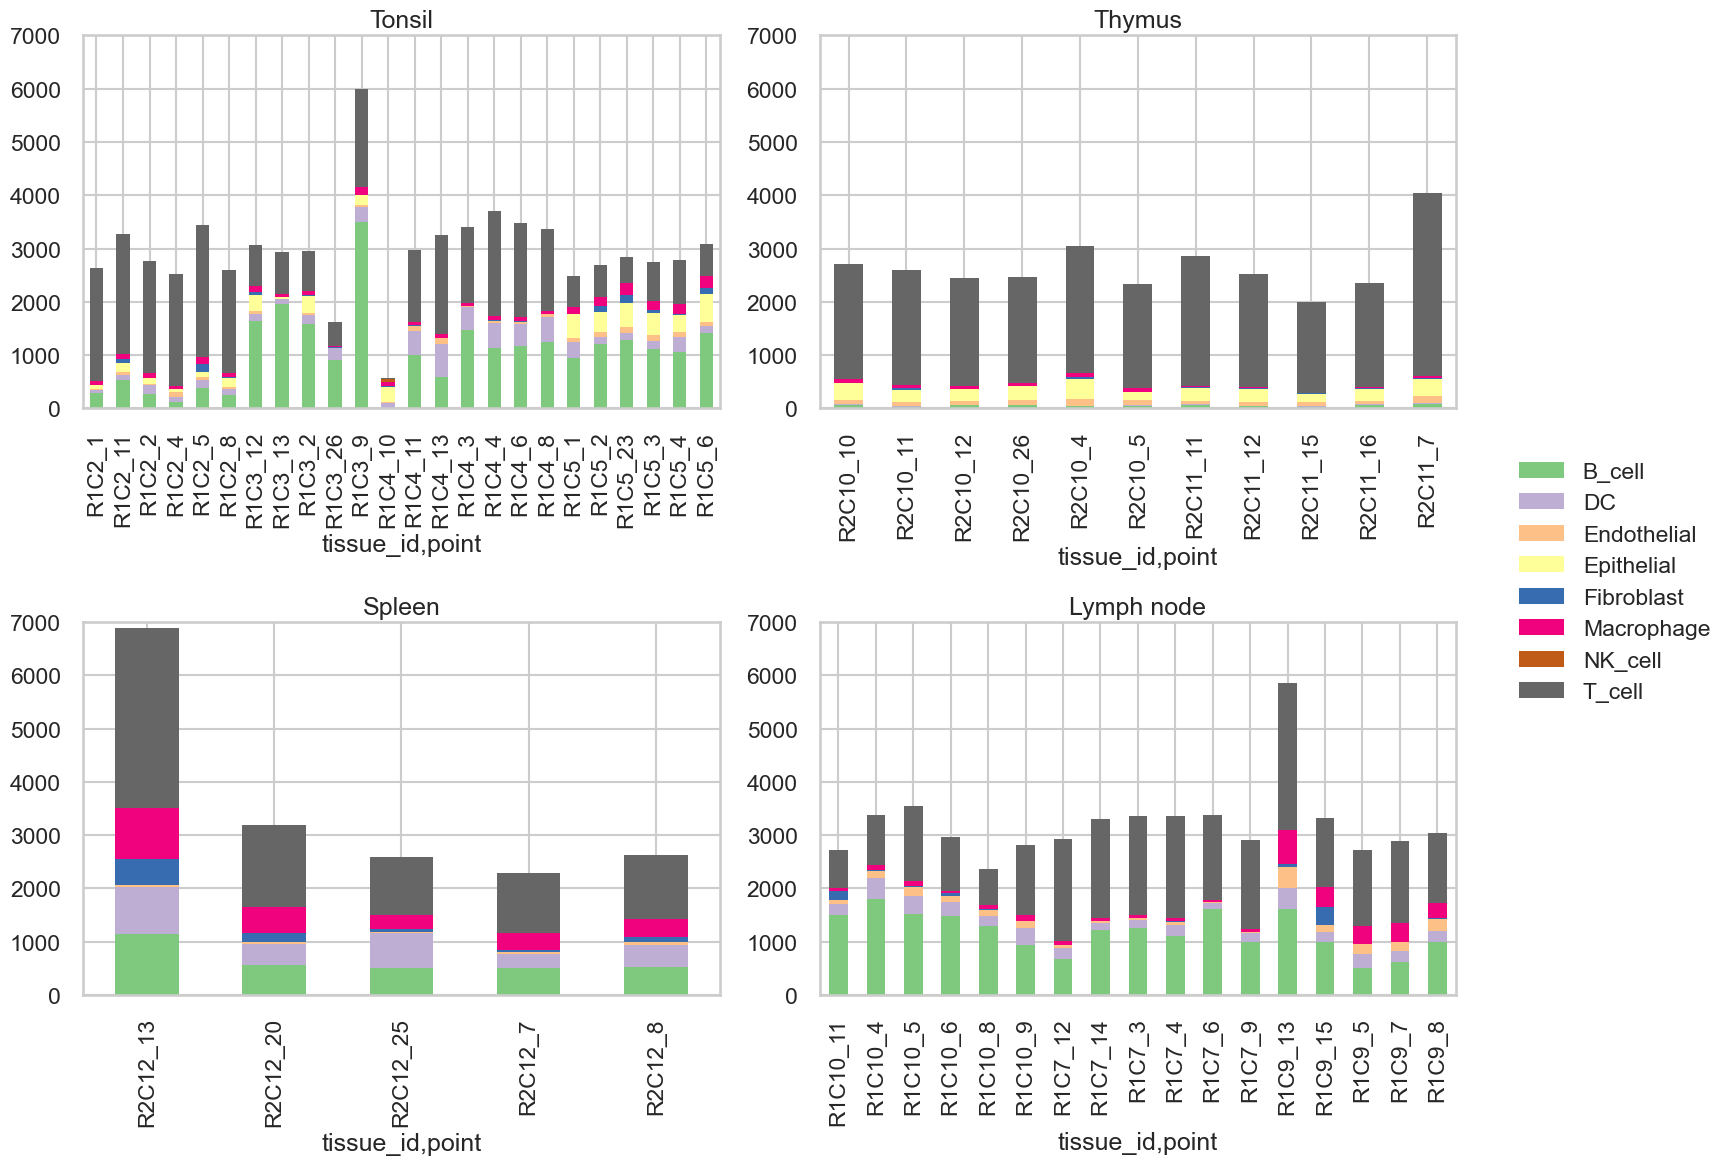

In [15]:
fig, axes = plt.subplots(2,2)
fig.set_size_inches(15,12)
for i, tiss in enumerate(interesting_tissues):
    ax = fig.axes[i]
    df_counts.loc[tiss].plot(kind='bar', stacked='True', ax=ax, edgecolor='none', legend=False, cmap='Accent')
    ax.set_xticklabels(df_counts.loc[tiss].index.map(lambda x: '{}_{}'.format(x[0],x[1])))
    ax.set_title(tiss)
    ax.set_ylim(0,7000)
h,l = ax.get_legend_handles_labels()
fig.legend(handles=h, labels=l, loc='center left', bbox_to_anchor=(1.01,0.5))

plt.tight_layout()
plt.savefig('{}/liu_bars_by_cell_types.png'.format(save_dir), dpi=300)

Dropping outliers that are more than 1.96 std 

In [16]:
df_counts['total'] = df_counts.sum(axis=1)
df_counts['zscore'] = df_counts.reset_index().groupby("tissue").total.transform(stats.zscore).values
df_counts = df_counts[df_counts.zscore.map(np.abs)<=1.96]
df_counts = df_counts.drop(columns=['zscore'])
df_counts.head()

phenotype                   B_cell     DC  Endothelial  Epithelial  \
tissue     tissue_id point                                           
Lymph node R1C10     11     1507.0  195.0         85.0         NaN   
                     4      1804.0  391.0        138.0         NaN   
                     5      1524.0  328.0        171.0         NaN   
                     6      1489.0  254.0        122.0         NaN   
                     8      1299.0  189.0        111.0         NaN   

phenotype                   Fibroblast  Macrophage  NK_cell  T_cell   total  
tissue     tissue_id point                                                   
Lymph node R1C10     11          163.0        66.0      NaN   706.0  2722.0  
                     4            17.0        87.0      NaN   940.0  3377.0  
                     5            19.0       104.0      NaN  1397.0  3543.0  
                     6            44.0        43.0      NaN  1022.0  2974.0  
                     8            11.0        80.0      NaN   675.0  2365.0

In [17]:
def err_add_to_mul(val_arr, err_arr):
    return ((val_arr + err_arr)/(val_arr - err_arr))**0.5

We define a parameter of the diameter of the cells to be addressed as the effective width of the sample

In [18]:
cell_vols = np.array([200,2000,1000,1000,2000,3000,200,200])
cell_diam = pd.Series(2*(cell_vols*3/4/np.pi)**(1/3), index=df_counts.columns[:-1])
cell_diam += 0.5
cell_diam

phenotype
B_cell          7.755663
DC             16.131853
Endothelial    12.907010
Epithelial     12.907010
Fibroblast     16.131853
Macrophage     18.394005
NK_cell         7.755663
T_cell          7.755663
dtype: float64

In [19]:
cd_df = pd.DataFrame(cell_diam, columns=['diam'])
cd_df['lin_unc'] = np.array([1,3,2,2,3,5,1,1])
cd_df['unc_fac'] = err_add_to_mul(cd_df.diam, cd_df.lin_unc)

We use the information regarding the area of the sample together with the effective width to calculate the density

In [20]:
area = 400**2
height = 10
dens = 10**12*df_counts/area/cd_df.diam
dens.total = dens.sum(axis=1)
df_counts = df_counts.reset_index()
dens = dens.reset_index()

In [21]:
dens.head()

phenotype      tissue tissue_id point        B_cell            DC  \
0          Lymph node     R1C10    11  1.214435e+09  7.554929e+07   
1          Lymph node     R1C10     4  1.453776e+09  1.514860e+08   
2          Lymph node     R1C10     5  1.228135e+09  1.270778e+08   
3          Lymph node     R1C10     6  1.199930e+09  9.840779e+07   
4          Lymph node     R1C10     8  1.046816e+09  7.322469e+07   

phenotype   Endothelial  Epithelial    Fibroblast    Macrophage  NK_cell  \
0          4.115980e+07         NaN  6.315146e+07  2.242579e+07      NaN   
1          6.682415e+07         NaN  6.586348e+06  2.956126e+07      NaN   
2          8.280384e+07         NaN  7.361213e+06  3.533760e+07      NaN   
3          5.907643e+07         NaN  1.704702e+07  1.461074e+07      NaN   
4          5.374986e+07         NaN  4.261755e+06  2.718277e+07      NaN   

phenotype        T_cell         total  
0          5.689391e+08  1.985661e+09  
1          7.575110e+08  2.465745e+09  
2          1.125790e+09  2.606505e+09  
3          8.235917e+08  2.212663e+09  
4          5.439573e+08  1.749192e+09

We want to be able to group by the patient (or not)

In [22]:
ids_by_tiss = dens.groupby('tissue').tissue_id.unique().map(lambda ll: {ll[i]: i for i in range(len(ll))})
id_dic = {}
for tis in ids_by_tiss.index:
    id_dic.update(ids_by_tiss[tis])
dens['id_'] = dens.tissue_id.map(id_dic)

Few figures for understanding the results (not used in the paper)

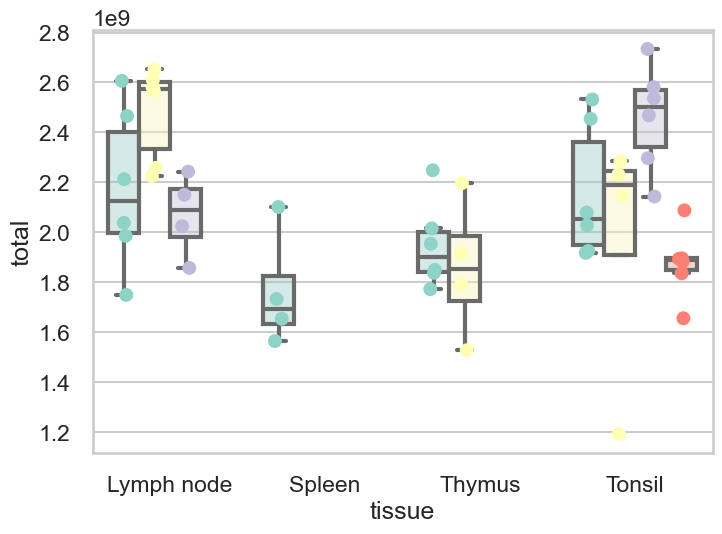

In [23]:
plt.figure()
ax= plt.gca()
sns.boxplot(data=dens, x='tissue', y='total', hue='id_', showfliers=False, palette='Set3')
sns.stripplot(data=dens, x='tissue', y='total', hue='id_', s=10, palette='Set3',dodge=True)
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .4))
ax.get_legend().remove()

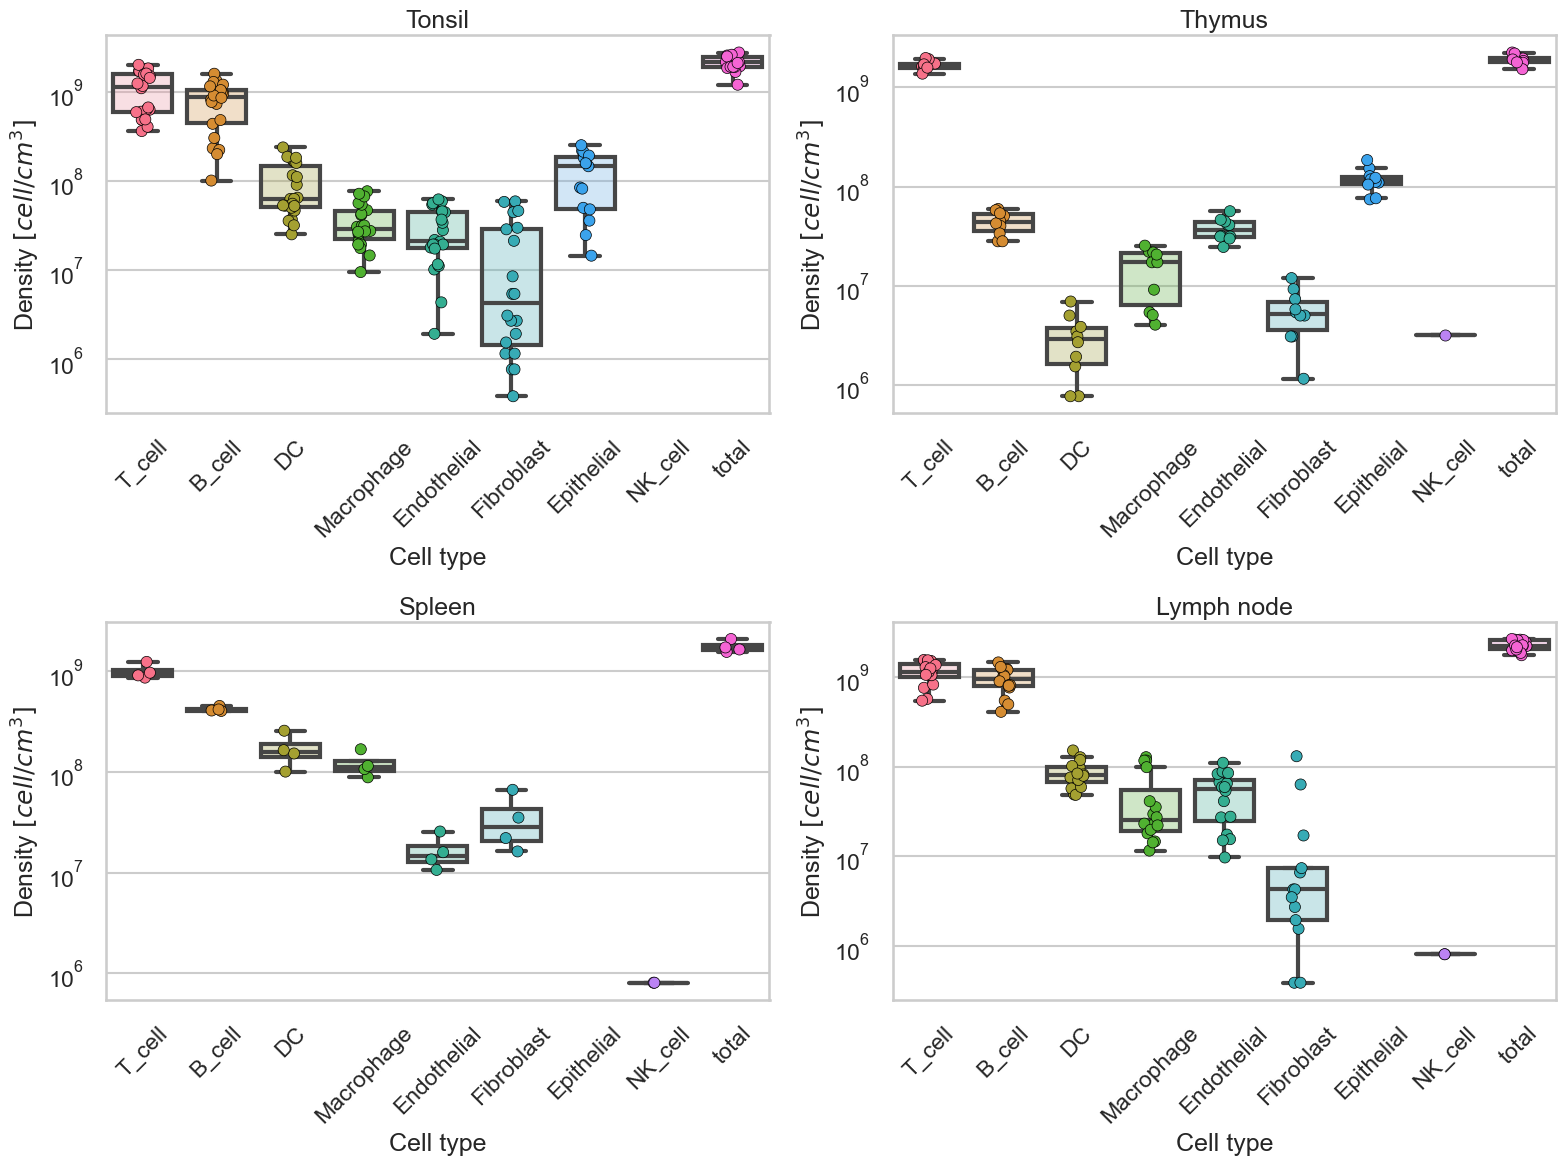

In [24]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(16, 12)
val_name = "Density $[cell/cm^{3}]$"
var_name = "Cell type"
dens_melt = dens.melt(
    id_vars=["tissue"],
    value_vars=list(df.phenotype.unique()) + ["total"],
    var_name=var_name,
    value_name=val_name,
)
for i, tiss in enumerate(interesting_tissues):
    ax = fig.axes[i]
    sns.boxplot(
        data=dens_melt.loc[dens_melt.tissue == tiss],
        x=var_name,
        y=val_name,
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        data=dens_melt.loc[dens_melt.tissue == tiss],
        x=var_name,
        y=val_name,
        hue=var_name,
        s=8,
        ax=ax,
        edgecolor="k",
        linewidth=0.5,
    )
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))
    ax.get_legend().remove()
    ax.set_title(tiss)
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.tight_layout()

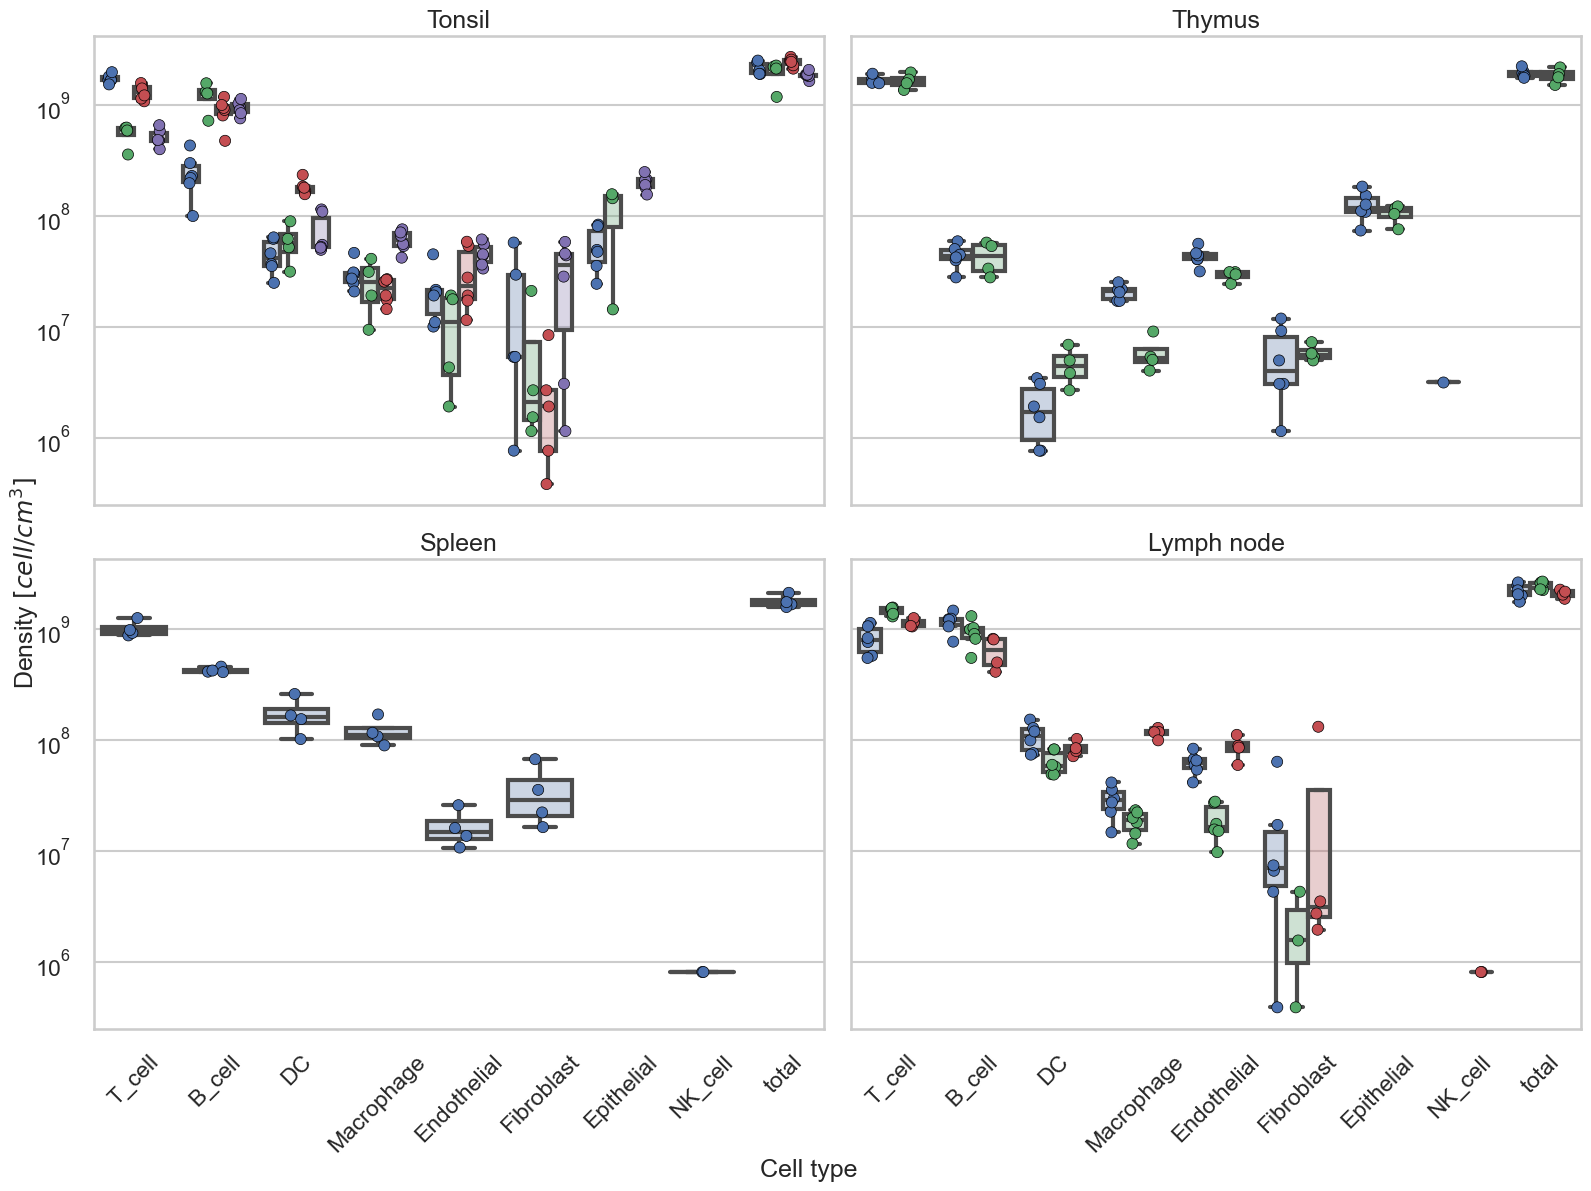

In [25]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(16, 12)
val_name = "Density $[cell/cm^{3}]$"
var_name = "Cell type"
dens_melt = dens.melt(
    id_vars=["tissue", "tissue_id", "id_"],
    value_vars=list(df.phenotype.unique()) + ["total"],
    var_name=var_name,
    value_name=val_name,
)
for i, tiss in enumerate(interesting_tissues):
    ax = fig.axes[i]
    sns.boxplot(
        data=dens_melt.loc[dens_melt.tissue == tiss],
        x=var_name,
        y=val_name,
        hue="tissue_id",
        showfliers=False,
        ax=ax,
    )
    sns.stripplot(
        data=dens_melt.loc[dens_melt.tissue == tiss],
        x=var_name,
        y=val_name,
        hue="tissue_id",
        s=8,
        ax=ax,
        edgecolor="k",
        linewidth=0.5,
        dodge=True,
    )
    for patch in ax.patches:
        r, g, b, a = patch.get_facecolor()
        patch.set_facecolor((r, g, b, 0.3))

    ax.get_legend().remove()
    ax.set_title(tiss)
    ax.set_yscale("log")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylabel("\n")
    ax.set_xlabel("")
fig.text(
    0.5,
    0.001,
    s=var_name,
    ha="center",
    va="bottom",
)
fig.text(
    0.001,
    0.5,
    s=val_name,
    ha="left",
    va="center",
    rotation=90,
)

plt.tight_layout()

### Uncertainty estimate

In [26]:
def mul_fac_sem(x):
    return np.exp(stats.sem(np.log(x)))


def gmean_new(x):
    return np.exp(np.mean(np.log(x)))


def perc_25(ser):
    return ser.quantile(0.25)


def perc_75(ser):
    return ser.quantile(0.75)


summ_liu = dens_melt.pivot_table(
    index=["tissue", "Cell type", "tissue_id"],
    values=val_name,
    aggfunc=["median", perc_25, perc_75, gmean_new, mul_fac_sem],
    fill_value=np.nan,
)
summ_liu = summ_liu.droplevel(level=1, axis=1)
new_column_names = {"gmean_new": "density", "mul_fac_sem": "unc"}
summ_liu2 = summ_liu[new_column_names.keys()].rename(columns=new_column_names).fillna(1)


def agg_density(df, cols=["density", "unc"]):
    output = pd.Series(dtype=float, index=cols)
    output[cols[0]] = gmean_new(df[cols[0]])
    output[cols[1]] = np.exp(
        np.sqrt(
            np.mean(np.log(df[cols[1]]) ** 2)
            + (stats.sem(np.log(df[cols[0]])) ** 2 if df.shape[0] > 1 else 0)
        )
    )
    return output


ct_densities = (
    summ_liu2.reset_index().groupby(["tissue", "Cell type"]).apply(agg_density)
)
direct_dens = dens_melt.pivot_table(
    index=["tissue", "Cell type"],
    values=val_name,
    aggfunc=[gmean_new, mul_fac_sem],
).fillna(1)
direct_dens = direct_dens.droplevel(level=1, axis=1).rename(columns=new_column_names)
ct_densities.join(direct_dens, rsuffix="_direct")

density       unc  density_direct  unc_direct
tissue     Cell type                                                      
Lymph node B_cell       8.469370e+08  1.253365    8.839360e+08    1.094747
           DC           8.082343e+07  1.198888    8.054783e+07    1.085221
           Endothelial  4.450338e+07  1.636275    4.113428e+07    1.206733
           Fibroblast   3.991053e+06  2.401151    4.687448e+06    1.000000
           Macrophage   3.786065e+07  1.780727    3.297443e+07    1.224622
           NK_cell      8.058627e+05  1.000000    8.058627e+05    1.000000
           T_cell       1.083347e+09  1.216083    1.079018e+09    1.086900
           total        2.225272e+09  1.074063    2.246341e+09    1.033082
Spleen     B_cell       4.216379e+08  1.026314    4.216379e+08    1.026314
           DC           1.601633e+08  1.211167    1.601633e+08    1.211167
           Endothelial  1.560080e+07  1.203994    1.560080e+07    1.203994
           Fibroblast   3.031233e+07  1.359280    3.031233e+07    1.359280
           Macrophage   1.165096e+08  1.144318    1.165096e+08    1.144318
           NK_cell      8.058627e+05  1.000000    8.058627e+05    1.000000
           T_cell       9.902245e+08  1.082967    9.902245e+08    1.082967
           total        1.752003e+09  1.066206    1.752003e+09    1.066206
Thymus     B_cell       4.245620e+07  1.156932    4.263251e+07    1.091850
           DC           2.681350e+06  1.724585    2.430353e+06    1.263655
           Endothelial  3.549470e+07  1.226552    3.688892e+07    1.082954
           Epithelial   1.127625e+08  1.153608    1.145858e+08    1.091590
           Fibroblast   5.011431e+06  1.343430    4.859249e+06    1.231741
           Macrophage   1.080854e+07  1.929368    1.229538e+07    1.249120
           NK_cell      3.223451e+06  1.000000    3.223451e+06    1.000000
           T_cell       1.672830e+09  1.061349    1.677863e+09    1.033612
           total        1.890251e+09  1.066465    1.900130e+09    1.035840
Tonsil     B_cell       6.815691e+08  1.494147    6.482863e+08    1.170806
           DC           7.356780e+07  1.420767    7.547764e+07    1.150162
           Endothelial  2.023998e+07  1.660872    2.219044e+07    1.204161
           Epithelial   8.813565e+07  1.546619    9.243193e+07    1.000000
           Fibroblast   5.105667e+06  1.974605    5.520442e+06    1.000000
           Macrophage   3.025736e+07  1.353385    3.112563e+07    1.122091
           T_cell       8.907188e+08  1.379615    9.322847e+08    1.130195
           total        2.079115e+09  1.111584    2.096144e+09    1.039639

In [27]:
def unc_of_mul(unc_facs_arr):
    log_unc_facs = np.log(unc_facs_arr)
    return np.exp((log_unc_facs**2).sum(axis=1)**0.5)

In [28]:
ct_densities['measurement_unc'] = 1
ct_densities.measurement_unc = ct_densities.index.get_level_values(1).map(cd_df.unc_fac.to_dict())
ct_densities.loc[ct_densities.index.get_level_values(1) == 'total', 'measurement_unc'] = cd_df.loc['T_cell'].unc_fac
ct_densities['unc_fac'] = unc_of_mul(ct_densities[['unc','measurement_unc']])
ct_densities


density       unc  measurement_unc   unc_fac
tissue     Cell type                                                     
Lymph node B_cell       8.469370e+08  1.253365         1.138441  1.297458
           DC           8.082343e+07  1.198888         1.207023  1.298690
           Endothelial  4.450338e+07  1.636275         1.169075  1.676329
           Fibroblast   3.991053e+06  2.401151         1.207023  2.449610
           Macrophage   3.786065e+07  1.780727         1.321591  1.898115
           NK_cell      8.058627e+05  1.000000         1.138441  1.138441
           T_cell       1.083347e+09  1.216083         1.138441  1.264531
           total        2.225272e+09  1.074063         1.138441  1.159562
Spleen     B_cell       4.216379e+08  1.026314         1.138441  1.141377
           DC           1.601633e+08  1.211167         1.207023  1.308039
           Endothelial  1.560080e+07  1.203994         1.169075  1.274589
           Fibroblast   3.031233e+07  1.359280         1.207023  1.433378
           Macrophage   1.165096e+08  1.144318         1.321591  1.363036
           NK_cell      8.058627e+05  1.000000         1.138441  1.138441
           T_cell       9.902245e+08  1.082967         1.138441  1.164392
           total        1.752003e+09  1.066206         1.138441  1.155626
Thymus     B_cell       4.245620e+07  1.156932         1.138441  1.215423
           DC           2.681350e+06  1.724585         1.207023  1.779893
           Endothelial  3.549470e+07  1.226552         1.169075  1.293181
           Epithelial   1.127625e+08  1.153608         1.169075  1.235790
           Fibroblast   5.011431e+06  1.343430         1.207023  1.419192
           Macrophage   1.080854e+07  1.929368         1.321591  2.041937
           NK_cell      3.223451e+06  1.000000         1.138441  1.138441
           T_cell       1.672830e+09  1.061349         1.138441  1.153357
           total        1.890251e+09  1.066465         1.138441  1.155750
Tonsil     B_cell       6.815691e+08  1.494147         1.138441  1.524962
           DC           7.356780e+07  1.420767         1.207023  1.489476
           Endothelial  2.023998e+07  1.660872         1.169075  1.700373
           Epithelial   8.813565e+07  1.546619         1.169075  1.589162
           Fibroblast   5.105667e+06  1.974605         1.207023  2.025682
           Macrophage   3.025736e+07  1.353385         1.321591  1.509060
           T_cell       8.907188e+08  1.379615         1.138441  1.414737
           total        2.079115e+09  1.111584         1.138441  1.182155

Saving the estimate to be combined with values from the literature for producing best estiamtes of density

In [35]:
res_dir = "Data/Interim results"
ct_densities[['density','unc_fac']].to_csv(f'{res_dir}/Liu_lymph_system_density.csv')

### For summary figure

In [30]:
tiss_id_list = dens.groupby("tissue").tissue_id.unique()
all_df = pd.DataFrame(columns=summ_liu2.columns)
for tiss in dens_melt.tissue.unique():
    temp = pd.DataFrame(
        columns=summ_liu2.columns,
        index=pd.MultiIndex.from_product(
            [[tiss], dens_melt["Cell type"].unique(), tiss_id_list[tiss]]
        ),
    )
    all_df = pd.concat([all_df, temp])
all_df.index = pd.MultiIndex.from_tuples(all_df.index)
all_df.index = all_df.index.rename(summ_liu2.index.names)
all_df.density = summ_liu2.density
all_df.unc = summ_liu2.unc
all_df["measurement_unc"] = all_df.index.get_level_values(1).map(
    ct_densities.reset_index().set_index("Cell type").measurement_unc.to_dict()
)
all_df["total_unc"] = unc_of_mul(all_df[["unc", "measurement_unc"]])
cell_type_order = [
    "T_cell",
    "B_cell",
    "NK_cell",
    "DC",
    "Macrophage",
    "Epithelial",
    "Fibroblast",
    "Endothelial",
    "total",
]
all_df = all_df.reset_index()
all_df["Cell type"] = all_df["Cell type"].astype("category")
all_df["Cell type"] = all_df["Cell type"].cat.set_categories(cell_type_order)
all_df = all_df.sort_values(["tissue", "Cell type"])
all_df = all_df.set_index(["tissue", "Cell type", "tissue_id"])
all_df

density       unc  measurement_unc  \
tissue     Cell type   tissue_id                                            
Lymph node T_cell      R1C10      7.817461e+08  1.131252         1.138441   
                       R1C7       1.453982e+09  1.031436         1.138441   
                       R1C9       1.118608e+09  1.041044         1.138441   
           B_cell      R1C10      1.129690e+09  1.093386         1.138441   
                       R1C7       8.939246e+08  1.125204         1.138441   
...                                        ...       ...              ...   
Tonsil     Endothelial R1C5       4.544334e+07  1.099915         1.169075   
           total       R1C2       2.142576e+09  1.050925         1.138441   
                       R1C3       1.900687e+09  1.168767         1.138441   
                       R1C4       2.452412e+09  1.036270         1.138441   
                       R1C5       1.871001e+09  1.030862         1.138441   

                                  total_unc  
tissue     Cell type   tissue_id             
Lymph node T_cell      R1C10       1.195953  
                       R1C7        1.142596  
                       R1C9        1.145402  
           B_cell      R1C10       1.170493  
                       R1C7        1.191594  
...                                     ...  
Tonsil     Endothelial R1C5        1.200758  
           total       R1C2        1.148950  
                       R1C3        1.224840  
                       R1C4        1.143925  
                       R1C5        1.142450  

[90 rows x 4 columns]

In [31]:
def get_errorbar_array(vals, unc_facs):
    low_bars =  (1-1/unc_facs) * vals
    hi_bars =  (unc_facs-1) * vals
    return np.vstack((low_bars, hi_bars))

In [32]:
def put_panel_labels(axes,  letter_labels=list('ABCDEF'), x_left=-0.12, y_up=1.1):
    for i, ax in enumerate(axes):
        ax.text(x_left, y_up, letter_labels[i], transform=ax.transAxes, fontsize=11, va='top', ha='right')

In [33]:
save_dir = "Figures"
mpl.style.use("seaborn")
sns.set_style("whitegrid")
rc_pars = {
    "legend.facecolor": "white",
    "legend.framealpha": 0.85,
    "lines.linewidth": 1.5,
    "legend.edgecolor": "Black",
    "legend.frameon": True,
    "legend.fancybox": True,
    "legend.shadow": False,
}

inc_to_cm = 2.54
fig_inches = {
    "small": [np.round(9/inc_to_cm,1), np.round(6/inc_to_cm,1)],
    "medium": [np.round(11/inc_to_cm,1), np.round(11/inc_to_cm,1)],
    "large": [np.round(18/inc_to_cm,1), np.round(22/inc_to_cm,1)],
    }

fig_dpi = {
    "small": 300,
    "medium": 300,
    "large": 600,
    }

font_sizes = {
    "small": {'label': 9, 'title':10},
    "medium": {'label': 6.7, 'title':7.8},
    "large": {'label': 10, 'title':11},
    }

grid_lw = {
    "small": 0.3,
    "medium": 0.5,
    "large": 0.75,
    }

def set_rc_params(fig_size="medium"):
    rc_pars.update(
        {
            "figure.figsize": fig_inches[fig_size],
            "figure.dpi": fig_dpi[fig_size],
            "axes.labelsize": font_sizes[fig_size]['title'],
            "xtick.labelsize": font_sizes[fig_size]['label'],
            "font.size": font_sizes[fig_size]['title'],
            "ytick.labelsize": font_sizes[fig_size]['label'],
            "axes.titlesize": font_sizes[fig_size]['title'],
            "legend.title_fontsize": font_sizes[fig_size]['label']*0.9,
            "legend.fontsize": font_sizes[fig_size]['label']*0.9,
            'grid.linewidth': grid_lw[fig_size]
        }
    )
    plt.rcParams["figure.figsize"] = rc_pars["figure.figsize"]
    plt.rcParams["figure.dpi"] = rc_pars["figure.dpi"]
    plt.rcParams["legend.fontsize"] = rc_pars["legend.fontsize"]
    sns.set_context("talk", rc=rc_pars)


# Small: approximately 9 cm x 6 cm
# Medium: approximately 11 cm x 11 cm
# Large: approximately 18 cm x 22 cm

C:\Users\Ron Sender\AppData\Local\Temp\ipykernel_1396\4136828032.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn")


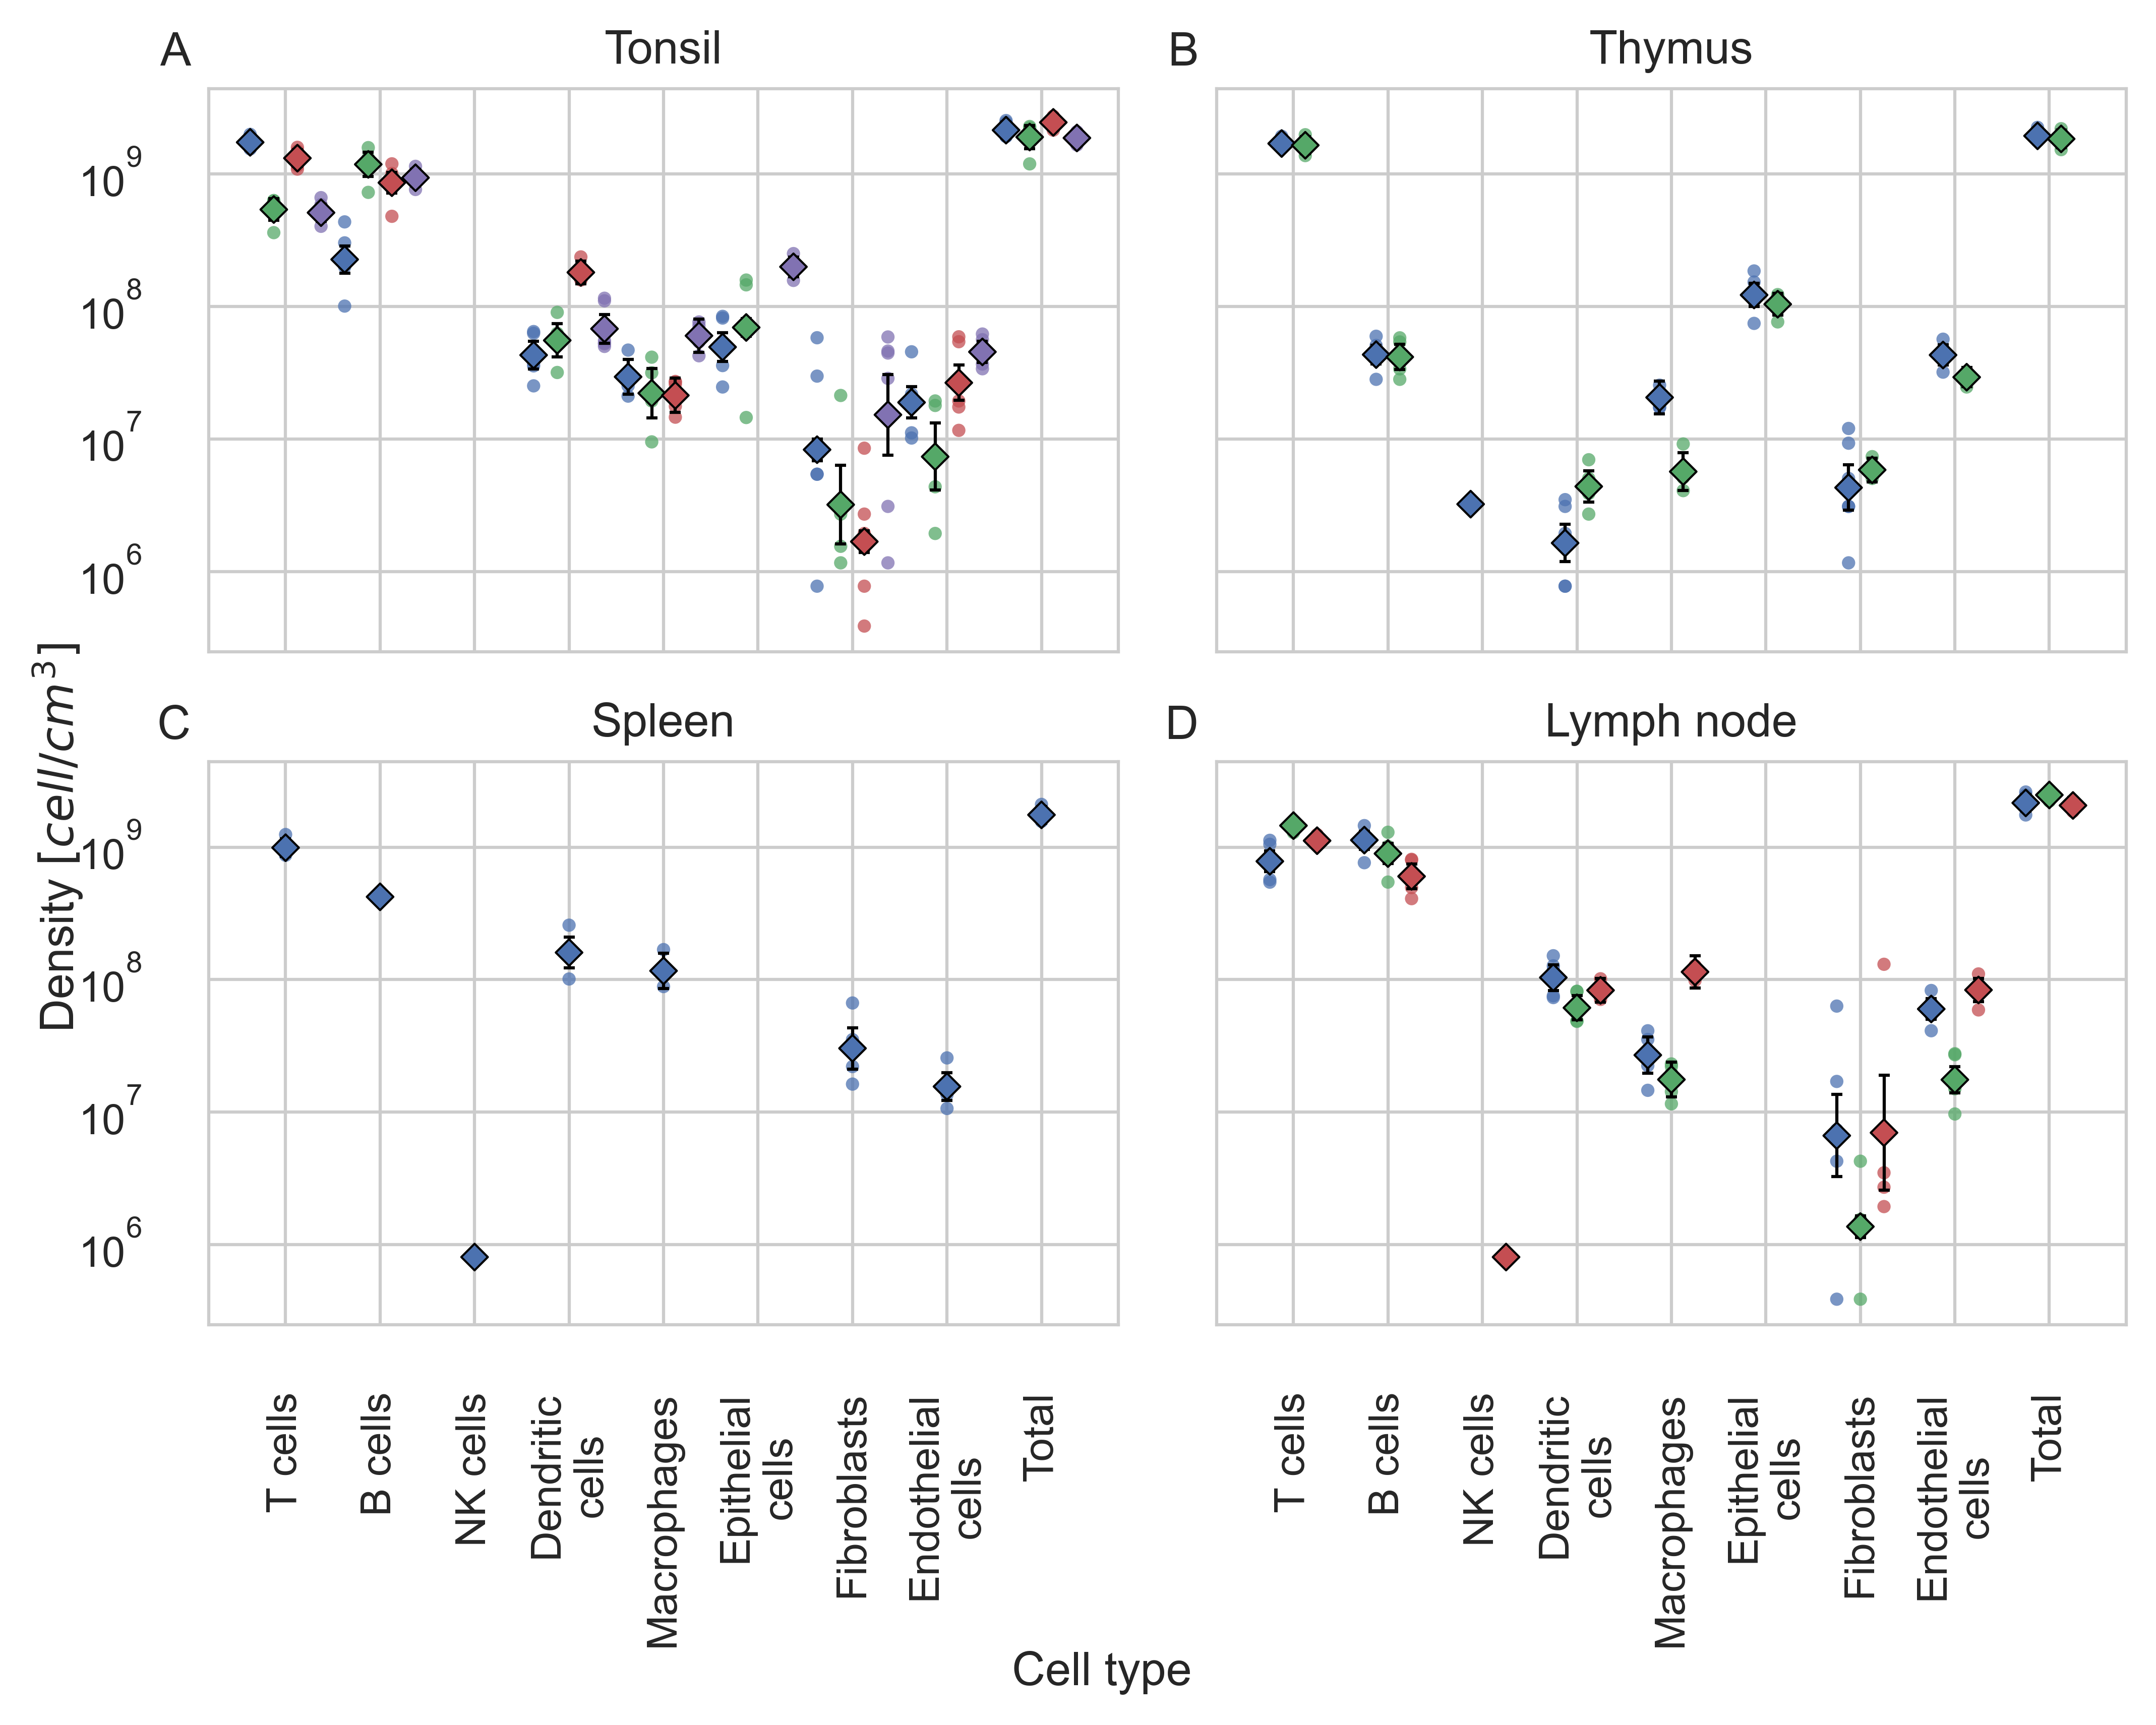

In [34]:
set_rc_params("large")
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(rc_pars["figure.figsize"][0], rc_pars["figure.figsize"][0]*4/5)
val_name = "Density $[cell/cm^{3}]$"
var_name = "Cell type"
dens_melt = dens.melt(
    id_vars=["tissue", "tissue_id", "id_"],
    value_vars=list(df.phenotype.unique()) + ["total"],
    var_name=var_name,
    value_name=val_name,
)
dens_melt = dens_melt.sort_values(["tissue", "Cell type"])

uniq_ids = all_df.reset_index().groupby("tissue").tissue_id.agg(lambda s: len(set(s)))
all_df["x"] = 0
dens_melt["x"] = 0
put_panel_labels(fig.axes, x_left=-0.02)
for i, tiss in enumerate(interesting_tissues):
    ax = fig.axes[i]
    nn = uniq_ids[tiss]
    ct_num = len(dens_melt["Cell type"].unique())
    all_df.loc[tiss, "x"] = np.arange(ct_num).repeat(uniq_ids[tiss]) + np.array(
        list(np.arange((1 - nn) / 8, (1 - nn) / 8 + nn / 4, 0.25)) * ct_num
    )
    dens_melt["x"] = dens_melt.apply(
        lambda rw: all_df.x.to_dict()[(rw.tissue, rw["Cell type"], rw.tissue_id)],
        axis=1,
    )
    yerr = get_errorbar_array(all_df.loc[tiss].density, all_df.loc[tiss].total_unc)
    sns.scatterplot(
        data=all_df.loc[tiss],
        x="x",
        y="density",
        hue="tissue_id",
        ax=ax,
        s=20,
        edgecolor="k",
        linewidth=0.5,
        zorder=10,
        style=np.ones(all_df.loc[tiss].shape[0]),
        markers=["D"],
    )
    ax.errorbar(
        x=all_df.loc[tiss].x,
        y=all_df.loc[tiss].density,
        yerr=yerr,
        ls="none",
        lw=1,
        zorder=9,
        marker="",
        color="k",
        capsize=1.3,
        capthick=0.75,
        elinewidth=0.75,
    )

    sns.scatterplot(
        data=dens_melt.loc[dens_melt.tissue == tiss],
        x="x",
        y=val_name,
        hue="tissue_id",
        s=10,
        ax=ax,
        linewidth=0.25,
        zorder=2,
        alpha=0.75,
        edgecolor="none",
    )
    ax.get_legend().remove()
    ax.set_title(tiss)
    ax.set_yscale("log")
    ax.set_xticks(range(ct_num))
    cell_types_list = (
        all_df.reset_index()["Cell type"]
        .drop_duplicates()
        .str.replace("_", " ")
        .replace({"total": "Total", "DC": "Dendritic\ncell"})
    )
    cell_types_list.loc[
        ~cell_types_list.isin(["Epithelial", "Endothelial", "Total"])
    ] += "s"
    cell_types_list.loc[
        cell_types_list.isin(["Epithelial", "Endothelial"])
    ] += "\ncells"
    ax.set_xticklabels(cell_types_list, rotation=90)
    ax.set_ylabel("\n")
    ax.set_xlabel("")
fig.text(
    0.5,
    0.001,
    s=var_name,
    ha="center",
    va="bottom",
)
fig.text(
    0.001,
    0.5,
    s=val_name,
    ha="left",
    va="center",
    rotation=90,
)

for ax in fig.axes:
    for side in ['top', 'bottom', 'left', 'right']:
        ax.spines[side].set(lw=0.75)
plt.tight_layout()
plt.savefig(f"{save_dir}/Figure_S1.pdf", dpi=rc_pars["figure.dpi"])
